## Workflow Example
The class will go through the 7 step workflow together to predict play values for a dataset of NHL data.

In [18]:
import numpy as np
import pandas as pd

import tensorflow.keras as keras

## Defining the problem and assembling a dataset
Our input features dataset will be play by play data for NHL games in 2017 -2018 season. The data is stored in a csv file which we can read using the pandas library. Our possible input features includes information of where and when the game was played, the type of play (shots, goals, hits, etc.), the players involved in the play, all the players on the ice for a given play, and x,y location data of the play. There is also indicator data at the end consisting of generated features by an expert.

In [19]:
allstats = pd.read_csv("/opt/data/thor_data/AllStats.csv", index_col=False)
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', len(allstats.columns))
allstats

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,DOW,MonthDay,Year,StartTime,EndTime,Location,Attendance,GameNumber,Visitor,Home,Period,Strength,TimeRemaining,Event,EventNumber,Description,ForPlayer,AgainstPlayer,Assist1,Assist1a,Assist2,EventLocation,TypeOfShot,ShotLocation,Distance,Away1,Away2,Away3,Away4,Away5,Away6,Home1,Home2,Home3,Home4,Home5,Home6,X,Y,ForI,N_Home,N_Away,TurnI,GoalieA,GoalieH,GoalieAI,GoalieHI,TimeToGoalHome,TimeToGoalAway,XC,YC,XC_ADJ,YC_ADJ,x_grid,y_grid,ScoreDiff,ThridPeriodI,ThirdPeriodSScoreDiff,MidLengthTimeToEvents,PenlType,ReboundHome,ReboundAway,RushShotHome,RushShotAway
0,Wednesday,October 4,2017,6:17,8:50,Bell MTS Place,15321,1,TORONTO MAPLE LEAFS,WINNIPEG JETS,1,EV,1200,FAC,5,TOR won Neu. Zone - TOR #43 KADRI vs WPG #55 S...,TORONTO MAPLE LEAFS_43_NAZEM KADRI,WINNIPEG JETS_55_MARK SCHEIFELE,NaN,NaN,NaN,Neu. Zone,NaN,NaN,NaN,TORONTO MAPLE LEAFS_12_PATRICK MARLEAU,TORONTO MAPLE LEAFS_43_NAZEM KADRI,TORONTO MAPLE LEAFS_47_LEO KOMAROV,TORONTO MAPLE LEAFS_22_NIKITA ZAITSEV,TORONTO MAPLE LEAFS_51_JAKE GARDINER,TORONTO MAPLE LEAFS_31_FREDERIK ANDERSEN,WINNIPEG JETS_55_MARK SCHEIFELE,WINNIPEG JETS_85_MATHIEU PERREAULT,WINNIPEG JETS_26_BLAKE WHEELER,WINNIPEG JETS_33_DUSTIN BYFUGLIEN,WINNIPEG JETS_39_TOBY ENSTROM,WINNIPEG JETS_35_STEVE MASON,NaN,NaN,1,6,6,NaN,TORONTO MAPLE LEAFS_31_FREDERIK ANDERSEN_G,WINNIPEG JETS_35_STEVE MASON_G,1,1,1200,1060,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,6.0,NaN,0,0,0,0
1,Wednesday,October 4,2017,6:17,8:50,Bell MTS Place,15321,1,TORONTO MAPLE LEAFS,WINNIPEG JETS,1,EV,1188,BLOCK,6,TOR #43 KADRI BLOCKED BY WPG #39 ENSTROM- Wri...,WINNIPEG JETS_39_TOBY ENSTROM,TORONTO MAPLE LEAFS_43_NAZEM KADRI,NaN,NaN,NaN,Def. Zone,Wrist,NaN,NaN,TORONTO MAPLE LEAFS_12_PATRICK MARLEAU,TORONTO MAPLE LEAFS_43_NAZEM KADRI,TORONTO MAPLE LEAFS_47_LEO KOMAROV,TORONTO MAPLE LEAFS_22_NIKITA ZAITSEV,TORONTO MAPLE LEAFS_51_JAKE GARDINER,TORONTO MAPLE LEAFS_31_FREDERIK ANDERSEN,WINNIPEG JETS_55_MARK SCHEIFELE,WINNIPEG JETS_85_MATHIEU PERREAULT,WINNIPEG JETS_26_BLAKE WHEELER,WINNIPEG JETS_33_DUSTIN BYFUGLIEN,WINNIPEG JETS_39_TOBY ENSTROM,WINNIPEG JETS_35_STEVE MASON,NaN,NaN,0,6,6,NaN,TORONTO MAPLE LEAFS_31_FREDERIK ANDERSEN_G,WINNIPEG JETS_35_STEVE MASON_G,1,1,1200,1048,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,19.0,NaN,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34756,Saturday,October 28,2017,7:09,10:08,BB&amp;T Center,13085,160,DETROIT RED WINGS,FLORIDA PANTHERS,4,EV,10,HIT,399,DET #39 MANTHA HIT FLA #21 TROCHECK- Def. Zone,DETROIT RED WINGS_39_ANTHONY MANTHA,FLORIDA PANTHERS_21_VINCENT TROCHECK,NaN,NaN,NaN,Def. Zone,NaN,NaN,NaN,DETROIT RED WINGS_40_HENRIK ZETTERBERG,DETROIT RED WINGS_39_ANTHONY MANTHA,DETROIT RED WINGS_83_TREVOR DALEY,DETROIT RED WINGS_35_JIMMY HOWARD,NaN,NaN,FLORIDA PANTHERS_11_JONATHAN HUBERDEAU,FLORIDA PANTHERS_21_VINCENT TROCHECK,FLORIDA PANTHERS_3_KEITH YANDLE,FLORIDA PANTHERS_34_JAMES REIMER,NaN,NaN,28.0,43.0,1,4,4,NaN,DETROIT RED WINGS_35_JIMMY HOWARD_G,FLORIDA PANTHERS_34_JAMES REIMER_G,1,1,1200,1200,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,0,8.0,NaN,0,0,0,0
34757,Saturday,October 28,2017,7:09,10:08,BB&amp;T Center,13085,160,DETROIT RED WINGS,FLORIDA PANTHERS,4,EV,3,SHOT,400,DET ONGOAL - #83 DALEY- Backhand- Off. Zone- 2...,DETROIT RED WINGS_83_TREVOR DALEY,NaN,NaN,NaN,NaN,Off. Zone,Backhand,NaN,21.0,DETROIT RED WINGS_40_HENRIK ZETTERBERG,DETROIT RED WINGS_39_ANTHONY MANTHA,DETROIT RED WINGS_83_TREVOR DALEY,DETROIT RED WINGS_35_JIMMY HOWARD,NaN,NaN,FLORIDA PANTHERS_63_EVGENII DADONOV,FLORIDA PANTHERS_71_RADIM VRBATA,FLORIDA PANTHERS_3_KEITH YANDLE,FLORIDA PANTHERS_34_JAMES REIMER,NaN,NaN,-77.0,-15.0,1,4,4,NaN,DETROIT RED WINGS_35_JIMMY HOWARD_G,FLORIDA PANTHERS_34_JAMES REIMER_G,1,1,1200,1200,77.0,15.0,77.0,10.0,2.0,0.0,-1,0,0,5.0,NaN,0,0,0,1


In [20]:
allstats.columns

Index(['DOW', 'MonthDay', 'Year', 'StartTime', 'EndTime', 'Location',
       'Attendance', 'GameNumber', 'Visitor', 'Home', 'Period', 'Strength',
       'TimeRemaining', 'Event', 'EventNumber', 'Description', 'ForPlayer',
       'AgainstPlayer', 'Assist1', 'Assist1a', 'Assist2', 'EventLocation',
       'TypeOfShot', 'ShotLocation', 'Distance', 'Away1', 'Away2', 'Away3',
       'Away4', 'Away5', 'Away6', 'Home1', 'Home2', 'Home3', 'Home4', 'Home5',
       'Home6', 'X', 'Y', 'ForI', 'N_Home', 'N_Away', 'TurnI', 'GoalieA',
       'GoalieH', 'GoalieAI', 'GoalieHI', 'TimeToGoalHome', 'TimeToGoalAway',
       'XC', 'YC', 'XC_ADJ', 'YC_ADJ', 'x_grid', 'y_grid', 'ScoreDiff',
       'ThridPeriodI', 'ThirdPeriodSScoreDiff', 'MidLengthTimeToEvents',
       'PenlType', 'ReboundHome', 'ReboundAway', 'RushShotHome',
       'RushShotAway'],
      dtype='object')

Our output data is an expert defined set of values for each play. In this case the more positive the better the play was for the home team. The more negative the better the play was for the away team. A better play has a higher probability of leading to a score increase and thus winning the game. For example goals and shots are higher value compared to hits or penalties because goals and shots more directly lead to winning.

In [21]:
outputs= pd.read_csv("/opt/data/thor_data/Y1.csv", index_col=False)
outputs

,Y1
0,-0.010029
1,-0.001727
...,...
34756,0.000000
34757,-0.285710


## Choosing a measure of success
When determining success it is important to realize that this metric may not be the loss function. For example accuracy is a bad loss function but may be a good measure of success for your problem. This problem we are attempting to determine continuous values and thus should pick an appropriate metric.

We decided ot use mean absolute error since we want to know how far off form the true value we were but being too high or low does not matter. It is only how far we were off.

Our metrics also determine our baseline. A baseline is performance from a similar algorithm attempting the same problem. The baseline is vital to understanding our real performance. Usually we try to get non ANN baselines if possible. For this problem our baseline will be a linear regression which achieved an MSE of 0.005298620072236094.

In [22]:
import tensorflow.keras.metrics

metrics = [keras.metrics.mae]
metric_name = 'mean_absolute_error'

## Preparing your data
This is where we will pre-process the data for the ANN. We need to format out data so it can be used with ANNs. For example this dataset contains the names of the players which are strings. However ANNs require numbers so we need to transform our dataset into something the ANN can use.

We may also generate new features from the existing data called feature engineering. For example in this dataset the rush shots colums is a generated feature based on the other columns. Thus it is a function of other columns so a model could in theory calculate it by itself. However if we know that it is important we can upfront calculate it for our model.

We also want to format our data to make it easier for ANNs to process the existing data. For example we use can use transforms like PCA, or FFT to replace existing features with transformed versions that are easier to work with. We may also eliminate some features which we believe are irrelevant. We should also always normalization the features.

Data augmentation can also be done to increase our total samples. We can use subsets of pictures, or use different transformations on pictures like rotations, resample sequences at different lengths etc.  

For our NHL dataset we have an "expert" who told us to make a large input vector with an index for each possible player and put a 1 if they were on the ice as the home team and a -1 if they were on the ice as the away team. All other players have are set to 0. Also included is other information like the home team and a constant bias.

Fortunately for use this was already done and we can just load the file

In [23]:
features = pd.read_csv("/opt/data/thor_data/xAll.csv", index_col=False)
features

,TORONTO MAPLE LEAFS_12_PATRICK MARLEAU,TORONTO MAPLE LEAFS_43_NAZEM KADRI,TORONTO MAPLE LEAFS_47_LEO KOMAROV,TORONTO MAPLE LEAFS_22_NIKITA ZAITSEV,TORONTO MAPLE LEAFS_51_JAKE GARDINER,TORONTO MAPLE LEAFS_31_FREDERIK ANDERSEN,WINNIPEG JETS_55_MARK SCHEIFELE,WINNIPEG JETS_85_MATHIEU PERREAULT,WINNIPEG JETS_26_BLAKE WHEELER,WINNIPEG JETS_33_DUSTIN BYFUGLIEN,WINNIPEG JETS_39_TOBY ENSTROM,WINNIPEG JETS_35_STEVE MASON,WINNIPEG JETS,TORONTO MAPLE LEAFS,WINNIPEG JETS_16_SHAWN MATTHIAS,WINNIPEG JETS_40_JOEL ARMIA,WINNIPEG JETS_17_ADAM LOWRY,WINNIPEG JETS_8_JACOB TROUBA,WINNIPEG JETS_44_JOSH MORRISSEY,TORONTO MAPLE LEAFS_42_TYLER BOZAK,TORONTO MAPLE LEAFS_25_JAMES VAN RIEMSDYK,TORONTO MAPLE LEAFS_2_RON HAINSEY,TORONTO MAPLE LEAFS_16_MITCHELL MARNER,TORONTO MAPLE LEAFS_44_MORGAN RIELLY,WINNIPEG JETS_18_BRYAN LITTLE,WINNIPEG JETS_29_PATRIK LAINE,WINNIPEG JETS_27_NIKOLAJ EHLERS,TORONTO MAPLE LEAFS_11_ZACH HYMAN,TORONTO MAPLE LEAFS_29_WILLIAM NYLANDER,TORONTO MAPLE LEAFS_34_AUSTON MATTHEWS,TORONTO MAPLE LEAFS_23_ERIC FEHR,TORONTO MAPLE LEAFS_8_CONNOR CARRICK,...,ANAHEIM DUCKS_47_HAMPUS LINDHOLM,ANAHEIM DUCKS_83_KALLE KOSSILA,PITTSBURGH PENGUINS_15_RILEY SHEAHAN,FLORIDA PANTHERS_62_DENIS MALGIN,MONTREAL CANADIENS_34_MICHAEL MCCARRON,MONTREAL CANADIENS_38_NIKITA SCHERBAK,CALGARY FLAMES_77_MARK JANKOWSKI,MINNESOTA WILD_82_JUSTIN KLOOS,COLORADO AVALANCHE_24_A.J. GREER,COLORADO AVALANCHE_57_GABRIEL BOURQUE,BUFFALO SABRES_38_ZACH REDMOND,ST. LOUIS BLUES_39_NATE PROSSER,ST. LOUIS BLUES_78_BEAU BENNETT,NEW YORK RANGERS_24_BOO NIEVES,PITTSBURGH PENGUINS_5_ZACH TROTMAN,WINNIPEG JETS_15_MATT HENDRICKS,LOS ANGELES KINGS_52_MICHAEL AMADIO,OTTAWA SENATORS_78_FILIP CHLAPIK,OTTAWA SENATORS_89_MAX MCCORMICK,DETROIT RED WINGS_72_ANDREAS ATHANASIOU,DALLAS STARS_29_GREG PATERYN,WASHINGTON CAPITALS_18_CHANDLER STEPHENSON,OTTAWA SENATORS_29_JOHNNY ODUYA,OTTAWA SENATORS_53_JACK RODEWALD,TORONTO MAPLE LEAFS_24_KASPERI KAPANEN,TORONTO MAPLE LEAFS_32_JOSH LEIVO,ANAHEIM DUCKS_45_SAMI VATANEN,FLORIDA PANTHERS_50_CHASE BALISY,CONSTANT,ZS,SE,SE*TE
0,0,-1,0,0,0,0,1,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34756,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
34757,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


For example we can count the players on the ice for each team for the second play. We realize that there are 6 players and 1 team for home and away and the constant is assigned 1.

I can check this by grabbing the column names with -1 for the away team

In [24]:
pd.set_option('display.max_rows', 8)
features.iloc[1][features.iloc[1] == -1]

TORONTO MAPLE LEAFS_12_PATRICK MARLEAU     -1
TORONTO MAPLE LEAFS_43_NAZEM KADRI         -1
TORONTO MAPLE LEAFS_47_LEO KOMAROV         -1
TORONTO MAPLE LEAFS_22_NIKITA ZAITSEV      -1
TORONTO MAPLE LEAFS_51_JAKE GARDINER       -1
TORONTO MAPLE LEAFS_31_FREDERIK ANDERSEN   -1
TORONTO MAPLE LEAFS                        -1
Name: 1, dtype: int64

And the home team values of 1

In [25]:
features.iloc[1][features.iloc[1] == 1]

WINNIPEG JETS_55_MARK SCHEIFELE       1
WINNIPEG JETS_85_MATHIEU PERREAULT    1
WINNIPEG JETS_26_BLAKE WHEELER        1
WINNIPEG JETS_33_DUSTIN BYFUGLIEN     1
WINNIPEG JETS_39_TOBY ENSTROM         1
WINNIPEG JETS_35_STEVE MASON          1
WINNIPEG JETS                         1
CONSTANT                              1
Name: 1, dtype: int64

## Deciding on an evaluation protocol
This is where we decide how to split up our data when evaluating it against our previous metric. For example we may use a train and valid set to train and select hyperparameters for a model then use a hold out test set to present our results for publication. Or we may use a K-fold validation method. Keep in mind when spliting sets that the temporality of the data is important. For example we usually use the last day of the data as the test set if the data was collected over a multiple days.

For this dataset we are just going to take the first 3/4 as training and the last 1/4 as validation. We did this because this data is temporal and we want to see if we can predict future games with the training data.

In [26]:
n_samples = features.shape[0]
indicies = np.arange(n_samples)
np.random.shuffle(indicies)

val_split = 0.75

n_samples_train = int(n_samples*val_split)
train_indicies = indicies[:n_samples_train]
features_train = features.iloc[train_indicies]
output_train = outputs.iloc[train_indicies]

n_samples_valid = int(n_samples*(1-val_split))
valid_indicies = indicies[n_samples_train:n_samples_train+n_samples_valid]
features_valid = features.iloc[valid_indicies]
output_valid = outputs.iloc[valid_indicies]

## Developing your model that does better than a baseline
For this part we should pick our activation, optimizer and loss function. We will use these to make a basic ANN to start with. Our goal right now is to get the model to compile and run not to have amazing performance.

In [27]:
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop
import tensorflow.keras.losses
from tensorflow.keras.callbacks import History

last_layer_activation = 'linear'
optimizer = RMSprop(learning_rate=0.001)
loss_fn = keras.losses.mse

feature_size = features.shape[1]
layer_size = 20
n_epochs = 10
batch_size = 64

input_tensor = Input(shape=(feature_size,))
current_output = Dense(units=layer_size, 
                       activation='relu', 
                       )(input_tensor)
current_output = Dense(units=1, 
                       activation=last_layer_activation, 
                       )(current_output)
model = Model(inputs=input_tensor, outputs=current_output)

model.compile(loss=loss_fn, 
              metrics=metrics, 
              optimizer=optimizer)

model.summary()

history1 = model.fit(x=features_train, 
          y=output_train,
          validation_data=(features_valid, output_valid),
          batch_size=batch_size, 
          epochs=n_epochs)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 805)]             0         
                                                                 
 dense_25 (Dense)            (None, 20)                16120     
                                                                 
 dense_26 (Dense)            (None, 1)                 21        
                                                                 
Total params: 16,141
Trainable params: 16,141
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
408/408 [==============================] - 1s 2ms/step - loss: 399.5982 - mean_absolute_error: 2.0914 - val_loss: 0.0397 - val_mean_absolute_error: 0.1197
Epoch 2/10
408/408 [==============================] - 1s 2ms/step - loss: 4.1634 - mean_absolute_error: 0.4549 - val_loss: 1.1047 - val_mean_absolute_err

Plot our results from the above model

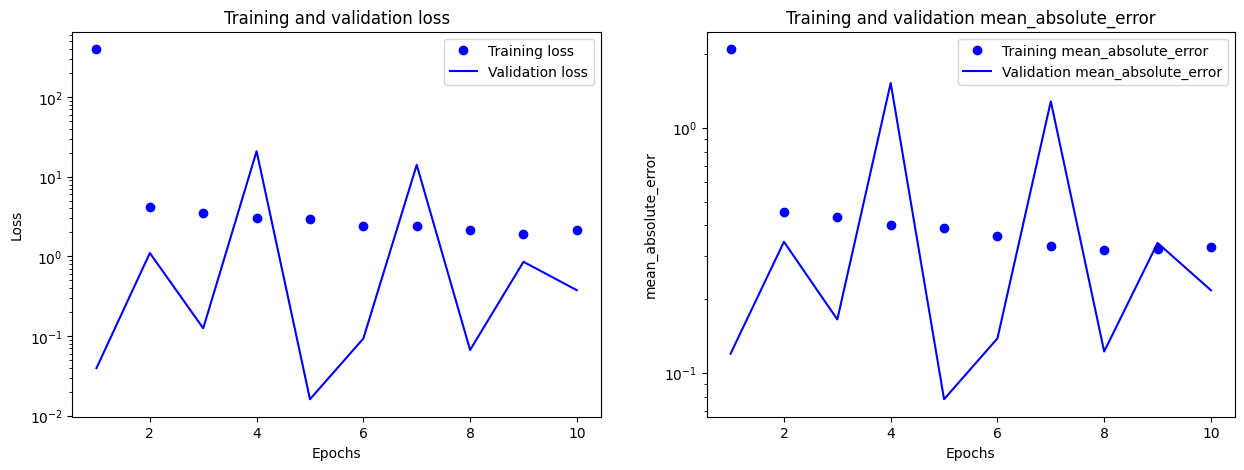

(2.132561445236206, 0.37704572081565857)

In [28]:
import matplotlib.pyplot as plt

history_current = history1
# make the figure a more rectangular size
plt.figure(figsize=(15, 5))

# loss
loss = history_current.history['loss']
val_loss = history_current.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,1)
plt.semilogy(epochs, loss, 'bo', label='Training loss')
plt.semilogy(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# metric
metric = history_current.history[metric_name]
val_metric = history_current.history['val_' + metric_name]

plt.subplot(1,2,2)
plt.semilogy(epochs, metric, 'bo', label='Training ' + metric_name)
plt.semilogy(epochs, val_metric, 'b', label='Validation ' + metric_name)
plt.title('Training and validation ' + metric_name)
plt.xlabel('Epochs')
plt.ylabel(metric_name)
plt.legend()

plt.show()
loss[-1], val_loss[-1]

The two numbers above are the MSE of the training and validation sets respectively. Remember our baseline MSE is 0.005298620072236094. Comparing the two we realize our model is probably pretty bad. Our next step is to try and fix that.


## Scaling up, developing a model that over fits
Starting from our basic model from before we want to make a larger model that can overfit to our data. That way we know it can achieve the results we want if we could make it generalize. If the training cannot achieve your desired performance then it would be naive to believe our validation/test set will have better performance.

In [29]:
feature_size = features.shape[1]
layer_size = 100
n_layers = 10
n_epochs = 10
batch_size = 64

input_tensor = Input(shape=(feature_size,))
current_output = input_tensor
for layer in range(n_layers):
    current_output = Dense(units=layer_size, 
                           activation='relu',
                          )(current_output)
current_output = Dense(units=1, 
                       activation=last_layer_activation)(current_output)
model = Model(inputs=input_tensor, outputs=current_output)

model.compile(loss=loss_fn, 
              metrics=metrics,
              optimizer=optimizer)

model.summary()

history2 = model.fit(x=features_train, 
          y=output_train,
          validation_data=(features_valid, output_valid),
          batch_size=batch_size, 
          epochs=n_epochs)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 805)]             0         
                                                                 
 dense_27 (Dense)            (None, 100)               80600     
                                                                 
 dense_28 (Dense)            (None, 100)               10100     
                                                                 
 dense_29 (Dense)            (None, 100)               10100     
                                                                 
 dense_30 (Dense)            (None, 100)               10100     
                                                                 
 dense_31 (Dense)            (None, 100)               10100     
                                                                 
 dense_32 (Dense)            (None, 100)               1010

Again we plot the results to comapre to the top

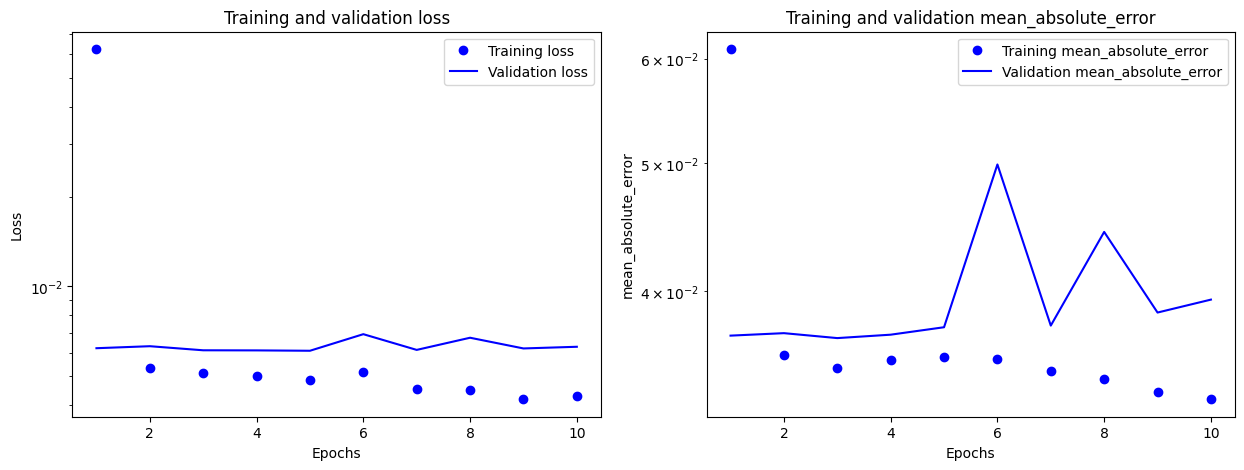

(0.004304864909499884, 0.006274736486375332)

In [30]:
import matplotlib.pyplot as plt

history_current = history2
# make the figure a more rectangular size
plt.figure(figsize=(15, 5))

# loss
loss = history_current.history['loss']
val_loss = history_current.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,1)
plt.semilogy(epochs, loss, 'bo', label='Training loss')
plt.semilogy(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# metric
metric = history_current.history[metric_name]
val_metric = history_current.history['val_' + metric_name]

plt.subplot(1,2,2)
plt.semilogy(epochs, metric, 'bo', label='Training ' + metric_name)
plt.semilogy(epochs, val_metric, 'b', label='Validation ' + metric_name)
plt.title('Training and validation ' + metric_name)
plt.xlabel('Epochs')
plt.ylabel(metric_name)
plt.legend()

plt.show()
loss[-1], val_loss[-1]

So looking at the MSE for training and validation above we see we beat the baseline MSE of 0.005298620072236094 in training but not validation. Our next step will be to correct that problem.


## Regularizing your model and tuning hyper parameters
Now that we have hopefully overfit and achieved acceptable performance we need to make sure our performance will generalize. To do this we will add regularization such as L1,L2 penalties, add dropout, or even change the architecture and input data format and augment the input. Sometimes deeper networks or larger networks have better regularization. You have to test out different hyper parameters to see what works best.

In [31]:
from tensorflow.keras.layers import  Concatenate, Add
import tensorflow.keras.regularizers as regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau

n_epochs = 50
batch_size = 128

def deepResNet(xInputSize):
    input_tensor = Input((xInputSize,))
    current_output_tensor = input_tensor

    l1 = 0.000001
    l2 = 0.0
    dropout_rate = 0.2
    sizes = [100] * 5

    current_output_tensor = Dense(units=sizes[0], 
                                  activation='relu', 
                                  kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)
                                 )(current_output_tensor)

    for units in sizes:
        block_input = current_output_tensor
        current_output_tensor = Dense(units=units, 
                                      activation='relu', 
                                      kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)
                                     )(current_output_tensor)
        current_output_tensor = Dense(units=units, 
                                      activation='relu', 
                                      kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)
                                     )(current_output_tensor)
        current_output_tensor = Dropout(rate=dropout_rate)(current_output_tensor)
        current_output_tensor = Add()([block_input, current_output_tensor])

    final_output_tensor = Dense(units=1, 
                                activation=last_layer_activation)(current_output_tensor)

    model = Model(inputs=input_tensor, outputs=final_output_tensor)
    return model

feature_size = features.shape[1]
model = deepResNet(feature_size)

rlr = ReduceLROnPlateau(monitor='loss', 
                        factor=0.8, 
                        patience=2)

model.compile(loss=loss_fn, 
              metrics=metrics, 
              optimizer=optimizer)

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 805)]        0           []                               
                                                                                                  
 dense_38 (Dense)               (None, 100)          80600       ['input_6[0][0]']                
                                                                                                  
 dense_39 (Dense)               (None, 100)          10100       ['dense_38[0][0]']               
                                                                                                  
 dense_40 (Dense)               (None, 100)          10100       ['dense_39[0][0]']               
                                                                                            

In [32]:
history3 = model.fit(x=features_train, 
          y=output_train,
          validation_data=(features_valid, output_valid),
          batch_size=batch_size, 
          epochs=n_epochs,
          callbacks=[rlr])

Epoch 1/50
204/204 [==============================] - 2s 5ms/step - loss: 3327.9919 - mean_absolute_error: 9.7952 - val_loss: 36.3648 - val_mean_absolute_error: 2.4721 - lr: 0.0010
Epoch 2/50
204/204 [==============================] - 1s 4ms/step - loss: 73.5600 - mean_absolute_error: 2.6486 - val_loss: 0.2700 - val_mean_absolute_error: 0.2283 - lr: 0.0010
Epoch 3/50
204/204 [==============================] - 1s 4ms/step - loss: 26.8863 - mean_absolute_error: 1.5660 - val_loss: 7.1191 - val_mean_absolute_error: 0.9178 - lr: 0.0010
Epoch 4/50
204/204 [==============================] - 1s 4ms/step - loss: 12.1768 - mean_absolute_error: 1.0823 - val_loss: 7.0883 - val_mean_absolute_error: 0.9291 - lr: 0.0010
Epoch 5/50
204/204 [==============================] - 1s 4ms/step - loss: 4.9205 - mean_absolute_error: 0.7113 - val_loss: 1.5135 - val_mean_absolute_error: 0.4731 - lr: 0.0010
Epoch 6/50
204/204 [==============================] - 1s 4ms/step - loss: 1.8224 - mean_absolute_error: 0.41

Now we show our final resutls

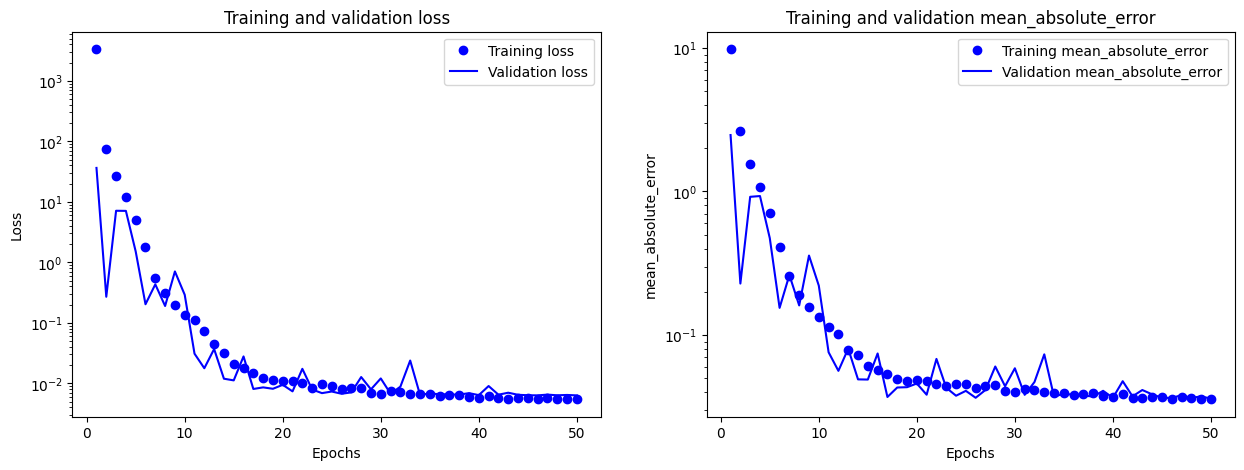

(0.005469613242894411, 0.006327877286821604)

In [33]:
import matplotlib.pyplot as plt

history_current = history3
# make the figure a more rectangular size
plt.figure(figsize=(15, 5))

# loss
loss = history_current.history['loss']
val_loss = history_current.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,1)
plt.semilogy(epochs, loss, 'bo', label='Training loss')
plt.semilogy(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# metric
metric = history_current.history[metric_name]
val_metric = history_current.history['val_' + metric_name]

plt.subplot(1,2,2)
plt.semilogy(epochs, metric, 'bo', label='Training ' + metric_name)
plt.semilogy(epochs, val_metric, 'b', label='Validation ' + metric_name)
plt.title('Training and validation ' + metric_name)
plt.xlabel('Epochs')
plt.ylabel(metric_name)
plt.legend()

plt.show()
loss[-1], val_loss[-1]

So then our final MSE was the last loss value:

In [34]:
loss[-1], val_loss[-1]

(0.005469613242894411, 0.006327877286821604)

Remember our linear regression achieved an MSE of 0.005298620072236094.

Wait did beat our baseline? I thought ANNs were the new big thing? How did a simple linear regression beat our fancy ANN?